In [162]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [164]:
import bnn.functions
import bnn.network
import bnn.layer
import bnn.loss

In [165]:
#dims = [32]*3 + [128]*3 + [1024]*10 + [128]*3 + [32]*10
dims = [d*2 for d in [8, 16, 32, 64, 64, 64, 32, 16, 8]]
TBNN = bnn.network.TernBinNetwork(*dims)

In [166]:
W_zero_prob = [0.3 + n for n in np.random.randn(len(TBNN.layers)) * 0.1]
W_mean = [
    (0.1 + n) * sign 
    for n, sign in 
    zip(
        np.random.randn(len(TBNN.layers)) * 0.1,
        np.sign(np.random.randn(len(TBNN.layers))),
    )
]

for zp, m in zip(W_zero_prob, W_mean):
    print(zp, m)

0.408426946345446 0.10586760659231062
0.26005735563796406 -0.1991624516166931
0.552528556217828 -0.04253173869426816
0.18809596949982604 -0.1397979887436225
0.2475557622896879 -0.13693336794186917
0.37204459378336074 -0.1627454469479679
0.15920479003430027 -0.22333524586010833
0.37911307450602744 -0.10465104633810599


In [167]:
TBNN._initialise(W_mean=W_mean, W_zero_prob=W_zero_prob)

In [168]:
# assert integers
for p in TBNN.parameters():
    all_ints = True
    if torch.is_floating_point(p) or torch.is_complex(p):
        print(p.dtype)
        all_ints = False

assert all_ints

In [169]:
samples = 100

input = bnn.functions.binarise(torch.randn(samples, dims[0])).to(torch.int)
desired = bnn.functions.binarise(torch.randn(samples, dims[-1])).to(torch.int)

In [170]:
output = TBNN.forward(input)
output.shape

torch.Size([100, 16])

In [171]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [172]:
loss = loss_func.forward(output=output, target=desired)
loss

tensor(1564)

In [173]:
grad = loss_func.backward(output=output, target=desired)
grad.shape

torch.Size([100, 16])

In [174]:
out_grad = TBNN.backward(grad)
out_grad.shape

torch.Size([100, 16])

In [175]:
# check grads and Ws match
for layer in TBNN.layers.values():
    layer: bnn.layer.TernBinLayer
    assert layer.W.shape == layer.W.grad.shape

In [176]:
list(TBNN.layers.values())[len(dims)//2].W.grad

tensor([[-13,  -5, -22,  ...,  10,  -8, -23],
        [ -9,   5,   4,  ..., -16,  -6, -11],
        [ 15,  29,  22,  ...,  -6,   6,  25],
        ...,
        [  1, -19,  -4,  ..., -12,   6,  -7],
        [  1, -11,   2,  ..., -16,   6,   1],
        [ 15,  -1,   8,  ..., -26,  26,   9]], dtype=torch.int32)

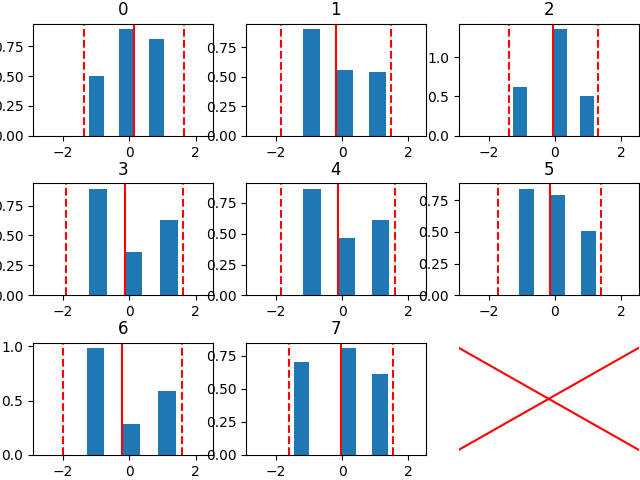

In [177]:
FIG_NAME = "W distribution"
plt.close(FIG_NAME)

data = [layer.W for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

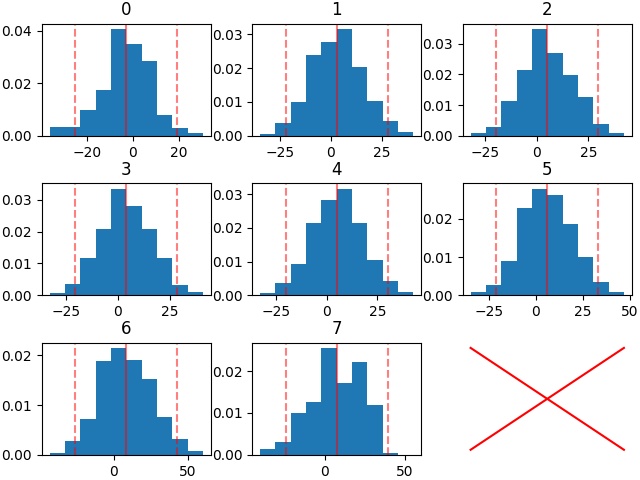

In [178]:
FIG_NAME = "W_grad distribution"
plt.close(FIG_NAME)

data = [layer.W.grad for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-", alpha=0.5)
        ax.axvline(mean+2*std, color="red", ls="--", alpha=0.5)
        ax.axvline(mean-2*std, color="red", ls="--", alpha=0.5)


for ax in axs:
    #ax.set_xlim(min_x, max_x)
    pass
        

fig.tight_layout(pad=0.1)

plt.show()

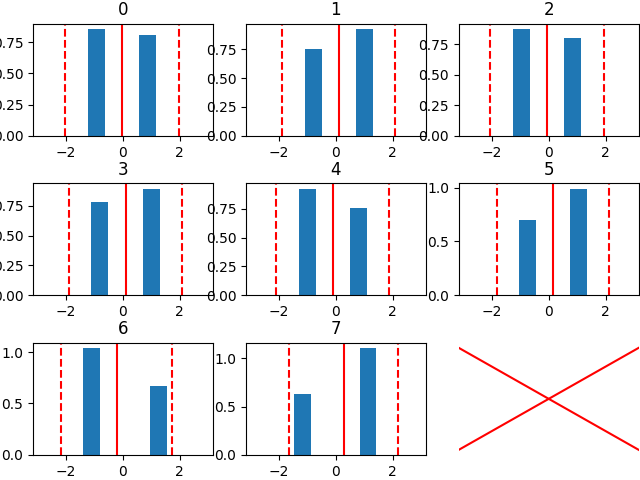

In [179]:
FIG_NAME = "activation distribution"
plt.close(FIG_NAME)

data = TBNN.input.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

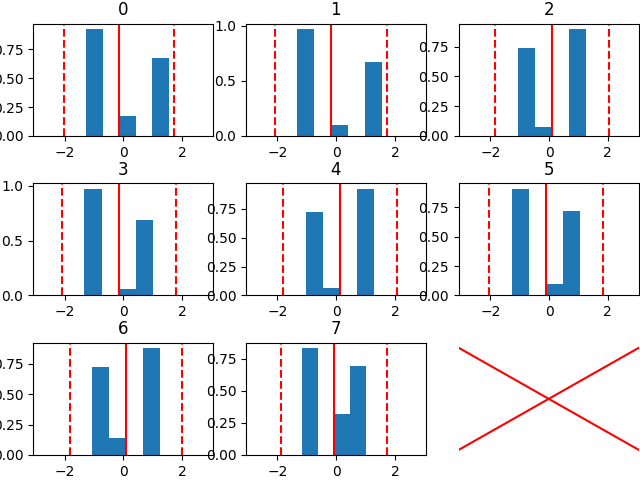

In [180]:
FIG_NAME = "grad distribution"
plt.close(FIG_NAME)

data = TBNN.grad.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()